---
title: "Thomas Fire Analysis"
description: "Using Python to Examine the Santa Barbara Thomas Fire"
author:
  - name: Naomi Moraes
    url: https://nmoraescommit.github.io/
    affilitation-url: https://bren.ucsb.edu/masters-programs/master-environmental-data-science
date: 2024-10-18
categories: [Python, MEDS, Geospatial]
toc: true
image: ThomasFire-coverpic.png # put in folder as with csl:
citation:
  url: https://nmoraescommit.github.io/blog/2024-12-01-thomas-fire-sb
draft: false
draft-mode: visible
---

# Introductory Data and Geospatial Analysis of the Santa Barbara Thomas Fire

![](image/fire.png)

The Thomas fire burns through Los Padres National Forest near Ojai, Calif., on Friday, Dec. 8, 2017. (AP Photo/Noah Berger)[source](https://www.accuweather.com/en/weather-news/intensifying-winds-threaten-to-fan-massive-thomas-fire-in-california-late-this-week/354104)

## About

#### Overview

The Santa Barbara Thomas Fre "... burned approximately 281,893 acres (440 sq mi; 114,078 ha) before being fully contained on January 12, 2018, making it the largest wildfire in modern California history at the time."[Wikipedia](https://en.wikipedia.org/wiki/Thomas_Fire) It was hugely detrimental to the impacted areas, economically and environmentally.

The purpose of this blogpost is to explore and visualize the impacts of the Santa Barbara Thomas Fire. In this post we will cover the impact the wildfire had on the air quality index of the surrounding area as well as the burn scar it produced.

The Air Quality Index (AQI) is a tool for reporting daily air quality. It tells you how clean or polluted your air is and what associated health effects might be a concern for you. Health effects can include negative long-term health impacts like "heart or lung disease, asthma attacks, heart attacks, irregular heartbeat, decreased lung function, and increased respiratory symptoms, such as irritation of the airways, coughing or difficulty breathing" as cited in [EPA.gov - EJScreen](https://www.epa.gov/ejscreen/ejscreen-indicators-overview-particulate-matter-25-pm25) . 

The visualization of the Thomas Fire burn scar allows us to see the preliminary impact the fire had on infrastructures, ecosystems, and communities - through its size, shape, and location.

#### Highlights

The AQI analysis portion of the project introduced me to working with fundamental python data cleaning tools, the DateTime module, as well as graph creation. The latter portion allowed me to try my hand with working with satellite data, false and true colour imagery creation, and map creation.

#### Data Information and Citations

**Landsat Data**: This contains red, green, blue, near-infrared and shortwave infrared bands from the Landsat Collection 2 Level-2, collected by the Landsat 8 satellite. The data was retrieved from the Microsoft Planetary Computer data catalogue and pre-processed to remove data outside land and coarsen the spatial resolution.

*Citation*: Microsoft Planetary Computer. Planetary Computer. (2018, January 12). https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2 

**Thomas Fire Perimeter Data**: This dataset was published and maintained by CAL FIRE, but accessed through Data.gov. The statewide fire history geospatial dataset is updated annually from the previous fire season, during spring, from units across the state and cooperating agencies.

*Citation*: Publisher CAL FIRE. (2024, May 14). State of California - california fire perimeters (all). Catalog. https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436 

**Air Quality Index (AQI)**: This dataset is sourced from the EPA’s AirData tool. These files are updated twice per year and is calculated daily for each monitor for the Criteria Gases and PM10 and PM2.5. For this analysis, I will use daily AQI data for 2017 and 2018. 

*Citation*: Environmental Protection Agency AirData (2024), Daily AQI by County [Data Set] Available from: https://www.epa.gov/outdoor-air-quality-data/download-daily-data. Access date: October 20, 2024.

#### Acknowledgements
This repository was created as the second and fourth assignments for the graduate course EDS 220: Working with Environmental Datasets in the Masters of Environmental Data Science (MEDS) program, taught by Dr. Carmen Galaz García.

#### GitHub Repository Link
[GitHub Link](https://github.com/nmoraescommit/eds220-hw4)

## Import Libraries

Importing all relevant libraries - for all excersizes in this blog post.

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import rioxarray as rioxr

## Air Quality Index Analysis

### Set-Up

In this section I will be plotting the daily AQI as well as 5-day average AQI from 2017-2018. First, I'll read in the data and clean the column namees for easier handling.

In [2]:
# Read in data
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip', compression = 'zip')
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip', compression = 'zip')

# Concatenate both dataframes
aqi = pd.concat([aqi_17, aqi_18])

# Simplify column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_')
                )

I'll then filter the data for AQI representative of Santa Barbara county only.

In [3]:
# Create filter Santa Barbara df with dropped columns
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']
aqi_sb = aqi_sb.drop(columns = ['state_name','county_name','state_code','county_code'], axis = 1)
               
# Change 'date' to datetime and set to index
aqi_sb.date = pd.to_datetime(aqi_sb['date'])
aqi_sb = aqi_sb.set_index('date')

We will use rolling averages to visualize short-term temporal trends. As my `datetime` column already has the day, I can use the `pandas.DataFrame.rolling()` method to get the average AQI within a 5 day window.

### Calculate Rolling Average

In [4]:
# Calculate AQI rolling average over 5 days
rolling_average = aqi_sb['aqi'].rolling('5D').mean()
               
# Create column with new variable 'rolling_variable'
aqi_sb['five_day_average'] = rolling_average

Finally I'll create a plot with the daily and five day average AI for Santa Barbara. This will give us a good understanding of how the AQI was impacted - in large part due to the Thomas Fire.

### Visualize Data

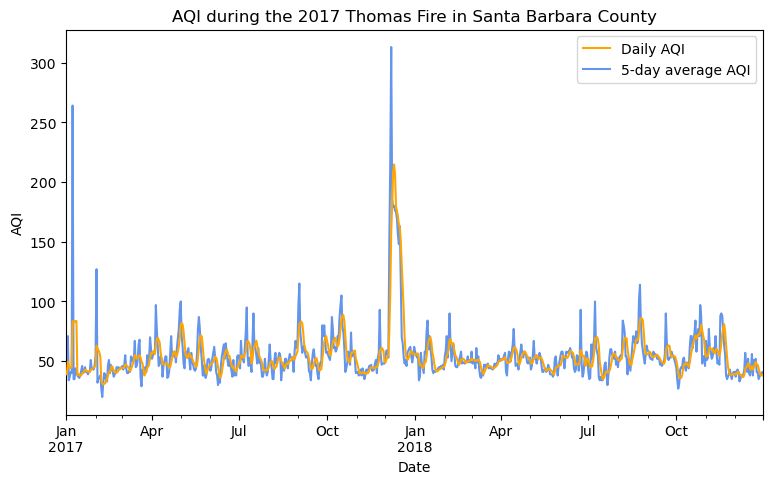

In [5]:
# Initialize figure
fig, ax = plt.subplots(figsize=(9,5))

# Add daily and 5-day average AQI
aqi_sb.five_day_average.plot(ax=ax, color = 'orange', zorder = 3)
aqi_sb.aqi.plot(ax=ax, color = 'cornflowerblue', zorder = 2)

# Update axis labels and title
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI during the 2017 Thomas Fire in Santa Barbara County')

# Add legend
ax.legend(labels = ['Daily AQI', '5-day average AQI'])

plt.show()

## Fire perimeter data retrieval and selection

### Set-Up

#### Import Data

In [6]:
# Display all columns when looking at dataframes
pd.set_option("display.max.columns", None)

In [7]:
# Create data filepath
fp = os.path.join('data','California_Fire_Perimeters_(all).shp')

# Create dataframe for CA fire perimeter shapefile
ca_fire_perimeter = gpd.read_file(fp)

#### Initial Data Exploration
In this section we will take a preliminary look at the imported fire perimeter data - in order to understand how to extract the Thomas Fire perimenter data.

In [8]:
# Check dataframe head
ca_fire_perimeter.head(3)

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,2023,CA,CDF,SKU,WHITWORTH,00004808,2023-06-17,2023-06-17,5,1,1,5.72913,None,None,{7985848C-0AC2-4BA4-8F0E-29F778652E61},None,None,2020,"POLYGON ((-13682443.000 5091132.739, -13682445..."
1,2023,CA,LRA,BTU,KAISER,00010225,2023-06-02,2023-06-02,5,1,1,13.60240,None,None,{43EBCC88-B3AC-48EB-8EF5-417FE0939CCF},None,None,2020,"POLYGON ((-13576727.142 4841226.161, -13576726..."
2,2023,CA,CDF,AEU,JACKSON,00017640,2023-07-01,2023-07-02,2,1,1,27.81450,None,None,{B64E1355-BF1D-441A-95D0-BC1FBB93483B},None,None,2020,"POLYGON ((-13459243.000 4621236.000, -13458968..."


In [9]:
# Check CRS - and type
ca_fire_perimeter.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

After the exploration of the California perimeter shape file, imported into this notebook, I see that is has 22,260 fire perimeter observations with columns for varied descriptive markers including: year, fire name, alarm date, and geometery. I observe that some of the column data types int64 and float64, however, I may want to change the date columns into datetime objects for manipulation. The CRS of this shapefile is a projected coordinate reference system, EPSG: 3857 and is a popular crs for web mapping services.

#### Clean Data

Next, I will clean the data for easier data manipulation.

In [10]:
# Simplify column names by replacing spaces and no capitilization
ca_fire_perimeter.columns = (ca_fire_perimeter.columns
                  .str.lower()
                  .str.replace(' ','_')
                )

# Make dates into DateTime object
ca_fire_perimeter.alarm_date = pd.to_datetime(ca_fire_perimeter.alarm_date)
ca_fire_perimeter.cont_date = pd.to_datetime(ca_fire_perimeter.cont_date)

#### Thomas Fire Boundary
Here, I will select for the Thomas Fire Boundary (2017), and save it as a new geospatial file.

In [11]:
# Select Thomas Fire in 2017
thomas_fire_boundary = ca_fire_perimeter[(ca_fire_perimeter['alarm_date'] > '2016-12-31') & 
                                         (ca_fire_perimeter['alarm_date'] < '2018-01-01') &
                                         (ca_fire_perimeter['fire_name'] == 'THOMAS')]

In [12]:
# View dataframe
thomas_fire_boundary

,year_,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,cause,c_method,objective,gis_acres,comments,complex_na,irwinid,fire_num,complex_id,decades,geometry
2654,2017,CA,USF,VNC,THOMAS,00003583,2017-12-04,2018-01-12,9,7,1,281791.0,CONT_DATE based on Inciweb,None,None,None,None,2010,"MULTIPOLYGON (((-13316089.016 4088553.040, -13..."


In [13]:
# Save dataframe as geospatial file in /data folder
thomas_fire_boundary.to_file('data/thomas_fire_boundary.geojson', driver = 'GeoJSON')

I chose to convert the alarm_date and cont_date variables into DateTime objects, and wanted them to retain that data type. As I would need to convert DateTime objects back into strings to save as shapefile, I chose to store the new data frame as a GeoJSON file. I have saved the data in the 'data/' folder common to this project.

## False and True Color Images

In a new notebook, I have created a path to the Thomas Fire perimeter data saved in the previous step.

### Import Data

In [14]:
# Set up file paths
land_fp = os.path.join('data', 'landsat8-2018-01-26-sb-simplified.nc')
thomas_fp = os.path.join('data', 'thomas_fire_boundary.geojson')

# Import landsat data
landsat = rioxr.open_rasterio(land_fp)

# Import Thomas Fire perimeter
thomas_fire_perimeter = gpd.read_file(thomas_fp)

### Explore Data

In this section we will take a preliminary look at the imported landsat data - in order to understand how to visualize it with respect to the Thomas Fire perimenter data.

In [15]:
# View landsat
landsat

<xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...

In [16]:
# View landsat sizes
landsat.sizes

Frozen({'y': 731, 'x': 870, 'band': 1})

In [17]:
# Landsat CRS
landsat.rio.crs

CRS.from_epsg(32611)

Through the exploration of the "landsat" xarray.Dataset, I have been able to notice the shape (5, 1, 731, 870) and the dimensions (x coordinates, y coordinates and 1 band). The data's variables has 5 groups of information - red, green, blue, near infrared 08, and short wave infrared 22. The crs of the dataset is ESPG: 32611.

### Clean Data

In this section, we will remove the band dimension of the Landsat data (as there is only 1).

In [18]:
# Drop the band dimension of the data
landsat = landsat.squeeze()

# Remove coordinates associated to band dimension
landsat = landsat.drop_vars('band')

# Check new landsat dataset
print(landsat.dims, landsat.coords)

Frozen({'y': 731, 'x': 870}) Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0


### Visualize Data

In this section, I will make some preliminary visuals of the landsat data. I will be making true and false color images.

#### True Color Image

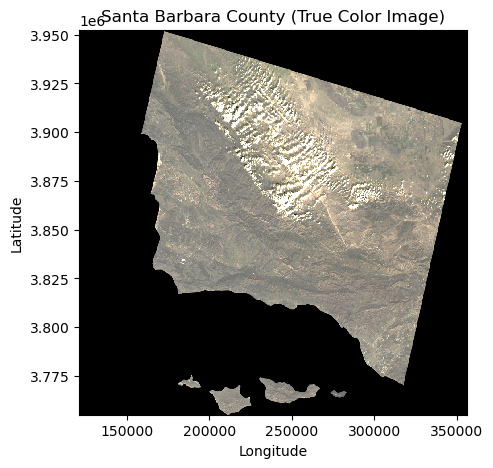

In [19]:
# Adjust the scale for plotting the bands for a true color image
fig, ax = plt.subplots(figsize = (5, 5)) # Set up plot

(landsat[['red', 'green', 'blue']]).to_array().plot.imshow(robust = True) # Plot Landsat True Color image

ax.set_title("Santa Barbara County (True Color Image)")  # Add title

# Set axis labels
ax.set_xlabel("Longitude") 
ax.set_ylabel("Latitude")

# Show map
plt.show()

#### False Color Image

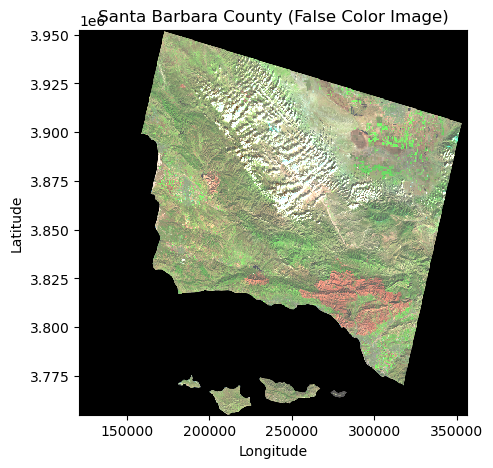

In [20]:
# Plot false color image
fig, ax = plt.subplots(figsize = (5, 5)) # Set up plot

(landsat[['swir22', 'nir08', 'red']]).to_array().plot.imshow(robust = True) # Plot landsat false color image

# Add title
ax.set_title("Santa Barbara County (False Color Image)") 

# Set axis labels
ax.set_xlabel("Longitude") 
ax.set_ylabel("Latitude")

# Show map
plt.show()

Notice how, in the false color image, the area approximating the Thomas Fires are a orange-red color compared to the rest of the green in the county.

### Map

In this final section, we will create maps of Santa Barbara overlayed with the Thomas Fire perimeter data (that we obtained in the fire perimeter notebook).

In [21]:
# Set CRS of landsat and thomas_fire_perimeter equivalent
thomas_fire_perimeter = thomas_fire_perimeter.to_crs(crs = landsat.rio.crs)

# Test if equivalencies true
assert thomas_fire_perimeter.crs == landsat.rio.crs

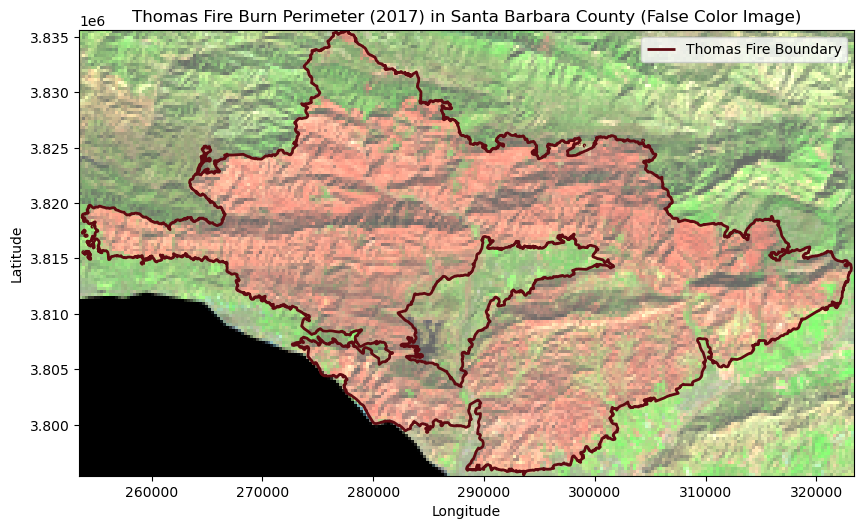

In [22]:
# Create bounding box for fire perimeters
landsat_bounded = landsat.rio.clip_box(*thomas_fire_perimeter.total_bounds)

# Clip map to fire perimeter bounds
fig, ax = plt.subplots(figsize = (10, 10)) # Setup plot
landsat_bounded[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax = ax, robust = True) # Plot the landsat bands

thomas_fire_perimeter.boundary.plot(ax = ax, edgecolor = '#5F0A11', linewidth = 2, label="Thomas Fire Boundary") # Plot the thomas fire data on same plot

# Add title
ax.set_title("Thomas Fire Burn Perimeter (2017) in Santa Barbara County (False Color Image)")  

# Set legend within map borders
ax.legend()

# Set axis labels
ax.set_xlabel("Longitude") 
ax.set_ylabel("Latitude")

# Set legend
ax.legend()

# Show map
plt.show()

#### Map Description

The 2 maps in the "Map" portion of this notebook, shows Santa Barbara County with fase color imagery - which include short wave infrared, near infrared, and red bands. The 2017 Thomas Fire burn perimeter is outlined in dark red, on top of this false image map, and it also appears red inside the perimeter (because of the false color imaging). This is due to the fact that it highly reflects shortwave infared. The Thomas Fire started 12/4/2017 and was contained on 1/12/2018. This imagery is therefore taken shortly after the fire was contained, on 1/26/2018.